In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

C:\Users\Yan family\Anaconda3\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.630920, acc.: 53.12%] [G loss: 0.559966]


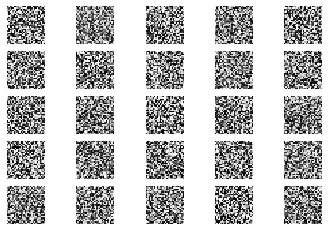

C:\Users\Yan family\Anaconda3\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.510867, acc.: 59.38%] [G loss: 0.596637]
2 [D loss: 0.469491, acc.: 65.62%] [G loss: 0.715747]
3 [D loss: 0.393374, acc.: 73.44%] [G loss: 0.843641]
4 [D loss: 0.302285, acc.: 89.06%] [G loss: 0.994689]
5 [D loss: 0.256714, acc.: 95.31%] [G loss: 1.161167]
6 [D loss: 0.237333, acc.: 100.00%] [G loss: 1.289825]
7 [D loss: 0.201591, acc.: 98.44%] [G loss: 1.330642]
8 [D loss: 0.155140, acc.: 100.00%] [G loss: 1.498551]
9 [D loss: 0.220180, acc.: 98.44%] [G loss: 1.542404]
10 [D loss: 0.190202, acc.: 100.00%] [G loss: 1.633560]
11 [D loss: 0.130748, acc.: 100.00%] [G loss: 1.745810]
12 [D loss: 0.118246, acc.: 100.00%] [G loss: 1.765391]
13 [D loss: 0.124866, acc.: 100.00%] [G loss: 1.893452]
14 [D loss: 0.113756, acc.: 100.00%] [G loss: 1.964793]
15 [D loss: 0.106931, acc.: 100.00%] [G loss: 2.022049]
16 [D loss: 0.084086, acc.: 100.00%] [G loss: 2.224096]
17 [D loss: 0.094222, acc.: 100.00%] [G loss: 2.140423]
18 [D loss: 0.082557, acc.: 100.00%] [G loss: 2.301659]
19 [D lo

148 [D loss: 0.194158, acc.: 95.31%] [G loss: 4.041170]
149 [D loss: 0.454686, acc.: 79.69%] [G loss: 3.043234]
150 [D loss: 0.224333, acc.: 89.06%] [G loss: 3.564783]
151 [D loss: 0.242208, acc.: 89.06%] [G loss: 3.848304]
152 [D loss: 0.157961, acc.: 95.31%] [G loss: 4.178518]
153 [D loss: 0.200481, acc.: 93.75%] [G loss: 3.586036]
154 [D loss: 0.177718, acc.: 95.31%] [G loss: 3.022546]
155 [D loss: 0.121327, acc.: 95.31%] [G loss: 3.255858]
156 [D loss: 0.165741, acc.: 92.19%] [G loss: 3.470613]
157 [D loss: 0.440805, acc.: 82.81%] [G loss: 4.084574]
158 [D loss: 0.442911, acc.: 76.56%] [G loss: 2.948237]
159 [D loss: 0.123979, acc.: 98.44%] [G loss: 3.698457]
160 [D loss: 0.262792, acc.: 87.50%] [G loss: 3.446398]
161 [D loss: 0.277450, acc.: 92.19%] [G loss: 2.835114]
162 [D loss: 0.148487, acc.: 92.19%] [G loss: 3.474519]
163 [D loss: 0.175697, acc.: 95.31%] [G loss: 3.372817]
164 [D loss: 0.157335, acc.: 93.75%] [G loss: 3.294257]
165 [D loss: 0.251823, acc.: 89.06%] [G loss: 3.

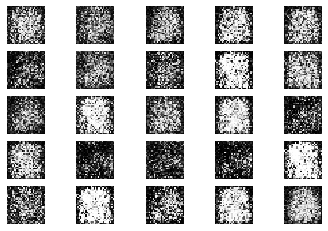

201 [D loss: 0.625008, acc.: 71.88%] [G loss: 1.773189]
202 [D loss: 0.482425, acc.: 73.44%] [G loss: 2.746691]
203 [D loss: 0.574303, acc.: 71.88%] [G loss: 2.395988]
204 [D loss: 0.553591, acc.: 73.44%] [G loss: 2.348927]
205 [D loss: 0.523836, acc.: 84.38%] [G loss: 2.545795]
206 [D loss: 0.533493, acc.: 75.00%] [G loss: 2.364438]
207 [D loss: 0.397512, acc.: 78.12%] [G loss: 2.446838]
208 [D loss: 0.714278, acc.: 60.94%] [G loss: 2.357869]
209 [D loss: 0.416624, acc.: 78.12%] [G loss: 3.003819]
210 [D loss: 0.596320, acc.: 70.31%] [G loss: 2.464192]
211 [D loss: 0.618968, acc.: 79.69%] [G loss: 2.420422]
212 [D loss: 0.523141, acc.: 75.00%] [G loss: 2.220474]
213 [D loss: 0.686108, acc.: 62.50%] [G loss: 2.386459]
214 [D loss: 0.751563, acc.: 53.12%] [G loss: 1.954226]
215 [D loss: 0.432566, acc.: 75.00%] [G loss: 2.631510]
216 [D loss: 0.681211, acc.: 67.19%] [G loss: 2.100860]
217 [D loss: 0.635092, acc.: 67.19%] [G loss: 1.985252]
218 [D loss: 0.576037, acc.: 65.62%] [G loss: 2.

351 [D loss: 0.677530, acc.: 62.50%] [G loss: 0.930670]
352 [D loss: 0.662338, acc.: 57.81%] [G loss: 0.855512]
353 [D loss: 0.692124, acc.: 48.44%] [G loss: 0.811219]
354 [D loss: 0.694639, acc.: 51.56%] [G loss: 0.899580]
355 [D loss: 0.646067, acc.: 59.38%] [G loss: 0.961008]
356 [D loss: 0.627795, acc.: 64.06%] [G loss: 0.942049]
357 [D loss: 0.655446, acc.: 67.19%] [G loss: 0.917571]
358 [D loss: 0.651813, acc.: 59.38%] [G loss: 1.004891]
359 [D loss: 0.617216, acc.: 64.06%] [G loss: 0.986840]
360 [D loss: 0.726828, acc.: 56.25%] [G loss: 0.929125]
361 [D loss: 0.592127, acc.: 62.50%] [G loss: 0.959102]
362 [D loss: 0.718129, acc.: 51.56%] [G loss: 0.948318]
363 [D loss: 0.668011, acc.: 62.50%] [G loss: 0.929696]
364 [D loss: 0.648334, acc.: 68.75%] [G loss: 0.837597]
365 [D loss: 0.654080, acc.: 59.38%] [G loss: 0.884886]
366 [D loss: 0.745068, acc.: 50.00%] [G loss: 0.896941]
367 [D loss: 0.610861, acc.: 70.31%] [G loss: 0.964844]
368 [D loss: 0.613439, acc.: 71.88%] [G loss: 0.

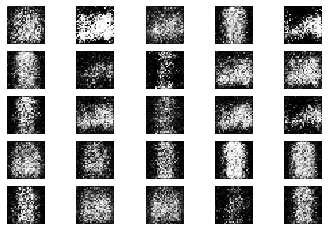

401 [D loss: 0.584370, acc.: 70.31%] [G loss: 0.906782]
402 [D loss: 0.584143, acc.: 73.44%] [G loss: 0.977260]
403 [D loss: 0.582995, acc.: 71.88%] [G loss: 0.959743]
404 [D loss: 0.652471, acc.: 54.69%] [G loss: 0.998990]
405 [D loss: 0.607818, acc.: 76.56%] [G loss: 0.986824]
406 [D loss: 0.583973, acc.: 70.31%] [G loss: 0.985575]
407 [D loss: 0.623901, acc.: 60.94%] [G loss: 0.902690]
408 [D loss: 0.595586, acc.: 64.06%] [G loss: 0.954587]
409 [D loss: 0.672606, acc.: 56.25%] [G loss: 0.963356]
410 [D loss: 0.594276, acc.: 70.31%] [G loss: 0.956085]
411 [D loss: 0.611425, acc.: 71.88%] [G loss: 0.992814]
412 [D loss: 0.729100, acc.: 51.56%] [G loss: 0.844560]
413 [D loss: 0.580634, acc.: 64.06%] [G loss: 0.930087]
414 [D loss: 0.524644, acc.: 76.56%] [G loss: 0.987776]
415 [D loss: 0.606703, acc.: 75.00%] [G loss: 1.053930]
416 [D loss: 0.612961, acc.: 64.06%] [G loss: 0.927345]
417 [D loss: 0.627681, acc.: 62.50%] [G loss: 0.965400]
418 [D loss: 0.588393, acc.: 67.19%] [G loss: 0.

548 [D loss: 0.701981, acc.: 54.69%] [G loss: 0.818270]
549 [D loss: 0.656487, acc.: 60.94%] [G loss: 0.868231]
550 [D loss: 0.645899, acc.: 65.62%] [G loss: 0.831394]
551 [D loss: 0.661661, acc.: 57.81%] [G loss: 0.880464]
552 [D loss: 0.715561, acc.: 54.69%] [G loss: 0.914317]
553 [D loss: 0.620581, acc.: 68.75%] [G loss: 0.870277]
554 [D loss: 0.675317, acc.: 56.25%] [G loss: 0.861249]
555 [D loss: 0.666247, acc.: 60.94%] [G loss: 0.797940]
556 [D loss: 0.727201, acc.: 42.19%] [G loss: 0.793982]
557 [D loss: 0.667832, acc.: 56.25%] [G loss: 0.791158]
558 [D loss: 0.624594, acc.: 62.50%] [G loss: 0.851171]
559 [D loss: 0.684861, acc.: 57.81%] [G loss: 0.820179]
560 [D loss: 0.680451, acc.: 57.81%] [G loss: 0.840162]
561 [D loss: 0.643033, acc.: 70.31%] [G loss: 0.790818]
562 [D loss: 0.690669, acc.: 54.69%] [G loss: 0.803989]
563 [D loss: 0.710413, acc.: 46.88%] [G loss: 0.753951]
564 [D loss: 0.638529, acc.: 62.50%] [G loss: 0.805436]
565 [D loss: 0.687343, acc.: 43.75%] [G loss: 0.

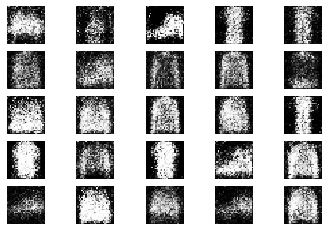

601 [D loss: 0.619537, acc.: 67.19%] [G loss: 0.788854]
602 [D loss: 0.613279, acc.: 68.75%] [G loss: 0.835387]
603 [D loss: 0.639444, acc.: 62.50%] [G loss: 0.856480]
604 [D loss: 0.618846, acc.: 67.19%] [G loss: 0.831030]
605 [D loss: 0.605455, acc.: 65.62%] [G loss: 0.832563]
606 [D loss: 0.721626, acc.: 50.00%] [G loss: 0.864696]
607 [D loss: 0.668198, acc.: 59.38%] [G loss: 0.825546]
608 [D loss: 0.627343, acc.: 65.62%] [G loss: 0.811749]
609 [D loss: 0.670713, acc.: 51.56%] [G loss: 0.900616]
610 [D loss: 0.664725, acc.: 67.19%] [G loss: 0.841679]
611 [D loss: 0.609227, acc.: 62.50%] [G loss: 0.811494]
612 [D loss: 0.610659, acc.: 70.31%] [G loss: 0.706793]
613 [D loss: 0.642623, acc.: 62.50%] [G loss: 0.711985]
614 [D loss: 0.666591, acc.: 62.50%] [G loss: 0.783087]
615 [D loss: 0.706138, acc.: 46.88%] [G loss: 0.879279]
616 [D loss: 0.597401, acc.: 71.88%] [G loss: 0.805553]
617 [D loss: 0.603376, acc.: 59.38%] [G loss: 0.795393]
618 [D loss: 0.665259, acc.: 54.69%] [G loss: 0.

750 [D loss: 0.667418, acc.: 59.38%] [G loss: 0.893189]
751 [D loss: 0.618785, acc.: 65.62%] [G loss: 0.876020]
752 [D loss: 0.642937, acc.: 62.50%] [G loss: 0.877856]
753 [D loss: 0.613600, acc.: 64.06%] [G loss: 0.849767]
754 [D loss: 0.636757, acc.: 59.38%] [G loss: 0.884201]
755 [D loss: 0.634939, acc.: 60.94%] [G loss: 0.893856]
756 [D loss: 0.641989, acc.: 57.81%] [G loss: 0.890637]
757 [D loss: 0.678289, acc.: 56.25%] [G loss: 0.799833]
758 [D loss: 0.676273, acc.: 48.44%] [G loss: 0.868650]
759 [D loss: 0.676447, acc.: 56.25%] [G loss: 0.833187]
760 [D loss: 0.657136, acc.: 62.50%] [G loss: 0.816776]
761 [D loss: 0.633288, acc.: 56.25%] [G loss: 0.843743]
762 [D loss: 0.676111, acc.: 54.69%] [G loss: 0.835440]
763 [D loss: 0.672152, acc.: 54.69%] [G loss: 0.829327]
764 [D loss: 0.656433, acc.: 60.94%] [G loss: 0.807497]
765 [D loss: 0.628801, acc.: 73.44%] [G loss: 0.808803]
766 [D loss: 0.595827, acc.: 65.62%] [G loss: 0.874599]
767 [D loss: 0.627064, acc.: 60.94%] [G loss: 0.

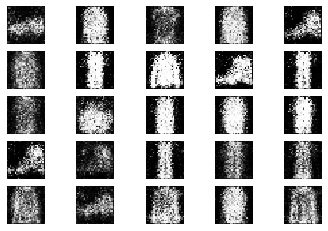

801 [D loss: 0.559654, acc.: 78.12%] [G loss: 0.834494]
802 [D loss: 0.632998, acc.: 65.62%] [G loss: 0.802038]
803 [D loss: 0.717377, acc.: 62.50%] [G loss: 0.849102]
804 [D loss: 0.647882, acc.: 62.50%] [G loss: 0.813669]
805 [D loss: 0.651882, acc.: 53.12%] [G loss: 0.751054]
806 [D loss: 0.647914, acc.: 64.06%] [G loss: 0.809379]
807 [D loss: 0.568530, acc.: 73.44%] [G loss: 0.813164]
808 [D loss: 0.681433, acc.: 56.25%] [G loss: 0.801713]
809 [D loss: 0.664156, acc.: 65.62%] [G loss: 0.887381]
810 [D loss: 0.639609, acc.: 62.50%] [G loss: 0.891694]
811 [D loss: 0.647019, acc.: 71.88%] [G loss: 0.856279]
812 [D loss: 0.626366, acc.: 57.81%] [G loss: 0.816637]
813 [D loss: 0.620122, acc.: 73.44%] [G loss: 0.845820]
814 [D loss: 0.625560, acc.: 70.31%] [G loss: 0.932490]
815 [D loss: 0.640136, acc.: 64.06%] [G loss: 0.790106]
816 [D loss: 0.697145, acc.: 51.56%] [G loss: 0.863679]
817 [D loss: 0.637031, acc.: 65.62%] [G loss: 0.799227]
818 [D loss: 0.652893, acc.: 60.94%] [G loss: 0.

948 [D loss: 0.610652, acc.: 70.31%] [G loss: 0.827070]
949 [D loss: 0.651347, acc.: 57.81%] [G loss: 0.846385]
950 [D loss: 0.679045, acc.: 54.69%] [G loss: 0.931441]
951 [D loss: 0.616693, acc.: 73.44%] [G loss: 0.849199]
952 [D loss: 0.658949, acc.: 59.38%] [G loss: 0.866206]
953 [D loss: 0.608021, acc.: 76.56%] [G loss: 0.855156]
954 [D loss: 0.635199, acc.: 59.38%] [G loss: 0.885644]
955 [D loss: 0.593952, acc.: 71.88%] [G loss: 0.835579]
956 [D loss: 0.618673, acc.: 65.62%] [G loss: 0.878562]
957 [D loss: 0.665091, acc.: 59.38%] [G loss: 0.881192]
958 [D loss: 0.679455, acc.: 56.25%] [G loss: 0.834400]
959 [D loss: 0.607510, acc.: 65.62%] [G loss: 0.869187]
960 [D loss: 0.659394, acc.: 68.75%] [G loss: 0.881835]
961 [D loss: 0.651488, acc.: 67.19%] [G loss: 0.870083]
962 [D loss: 0.702315, acc.: 60.94%] [G loss: 0.877087]
963 [D loss: 0.626796, acc.: 67.19%] [G loss: 0.859229]
964 [D loss: 0.599394, acc.: 68.75%] [G loss: 0.894271]
965 [D loss: 0.601738, acc.: 65.62%] [G loss: 0.

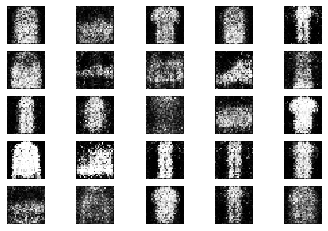

1001 [D loss: 0.604870, acc.: 70.31%] [G loss: 0.888209]
1002 [D loss: 0.615780, acc.: 70.31%] [G loss: 0.984408]
1003 [D loss: 0.596823, acc.: 71.88%] [G loss: 0.850542]
1004 [D loss: 0.601962, acc.: 70.31%] [G loss: 0.832787]
1005 [D loss: 0.631982, acc.: 65.62%] [G loss: 0.875912]
1006 [D loss: 0.624060, acc.: 65.62%] [G loss: 0.916311]
1007 [D loss: 0.586189, acc.: 71.88%] [G loss: 0.808836]
1008 [D loss: 0.701639, acc.: 53.12%] [G loss: 0.814659]
1009 [D loss: 0.674962, acc.: 50.00%] [G loss: 0.861846]
1010 [D loss: 0.607630, acc.: 70.31%] [G loss: 0.915724]
1011 [D loss: 0.657460, acc.: 59.38%] [G loss: 0.853026]
1012 [D loss: 0.662288, acc.: 59.38%] [G loss: 0.810248]
1013 [D loss: 0.657063, acc.: 59.38%] [G loss: 0.974802]
1014 [D loss: 0.680138, acc.: 59.38%] [G loss: 0.858192]
1015 [D loss: 0.608828, acc.: 67.19%] [G loss: 0.886715]
1016 [D loss: 0.658666, acc.: 59.38%] [G loss: 0.906775]
1017 [D loss: 0.672633, acc.: 54.69%] [G loss: 0.840068]
1018 [D loss: 0.652390, acc.: 5

1147 [D loss: 0.657817, acc.: 56.25%] [G loss: 0.891258]
1148 [D loss: 0.631657, acc.: 62.50%] [G loss: 0.866137]
1149 [D loss: 0.673418, acc.: 56.25%] [G loss: 0.855825]
1150 [D loss: 0.624291, acc.: 68.75%] [G loss: 0.882210]
1151 [D loss: 0.605787, acc.: 70.31%] [G loss: 0.786870]
1152 [D loss: 0.600631, acc.: 68.75%] [G loss: 0.899855]
1153 [D loss: 0.634177, acc.: 62.50%] [G loss: 0.890971]
1154 [D loss: 0.609492, acc.: 73.44%] [G loss: 0.826180]
1155 [D loss: 0.639541, acc.: 60.94%] [G loss: 0.795487]
1156 [D loss: 0.639898, acc.: 59.38%] [G loss: 0.789361]
1157 [D loss: 0.622395, acc.: 73.44%] [G loss: 0.847053]
1158 [D loss: 0.627607, acc.: 56.25%] [G loss: 0.822671]
1159 [D loss: 0.640366, acc.: 62.50%] [G loss: 0.879690]
1160 [D loss: 0.643779, acc.: 57.81%] [G loss: 0.849536]
1161 [D loss: 0.661811, acc.: 65.62%] [G loss: 0.773110]
1162 [D loss: 0.652872, acc.: 62.50%] [G loss: 0.775130]
1163 [D loss: 0.661807, acc.: 64.06%] [G loss: 0.813993]
1164 [D loss: 0.562121, acc.: 7

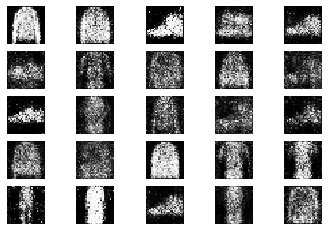

1201 [D loss: 0.663611, acc.: 57.81%] [G loss: 0.908330]
1202 [D loss: 0.612592, acc.: 65.62%] [G loss: 0.956543]
1203 [D loss: 0.640402, acc.: 59.38%] [G loss: 0.883615]
1204 [D loss: 0.569382, acc.: 68.75%] [G loss: 0.846751]
1205 [D loss: 0.653133, acc.: 56.25%] [G loss: 0.887684]
1206 [D loss: 0.628591, acc.: 65.62%] [G loss: 0.833548]
1207 [D loss: 0.609975, acc.: 65.62%] [G loss: 0.866599]
1208 [D loss: 0.616783, acc.: 67.19%] [G loss: 0.872932]
1209 [D loss: 0.651004, acc.: 62.50%] [G loss: 0.917771]
1210 [D loss: 0.618329, acc.: 68.75%] [G loss: 0.915038]
1211 [D loss: 0.616519, acc.: 62.50%] [G loss: 0.802663]
1212 [D loss: 0.689309, acc.: 53.12%] [G loss: 0.751433]
1213 [D loss: 0.610112, acc.: 62.50%] [G loss: 0.886805]
1214 [D loss: 0.609437, acc.: 68.75%] [G loss: 0.825478]
1215 [D loss: 0.597459, acc.: 65.62%] [G loss: 0.857692]
1216 [D loss: 0.626815, acc.: 64.06%] [G loss: 0.855556]
1217 [D loss: 0.665164, acc.: 59.38%] [G loss: 0.798684]
1218 [D loss: 0.637548, acc.: 6

1345 [D loss: 0.605643, acc.: 60.94%] [G loss: 0.919828]
1346 [D loss: 0.606954, acc.: 68.75%] [G loss: 0.870156]
1347 [D loss: 0.625113, acc.: 67.19%] [G loss: 0.912447]
1348 [D loss: 0.651208, acc.: 62.50%] [G loss: 0.849042]
1349 [D loss: 0.609718, acc.: 70.31%] [G loss: 0.818114]
1350 [D loss: 0.583746, acc.: 75.00%] [G loss: 0.876811]
1351 [D loss: 0.688592, acc.: 56.25%] [G loss: 0.938006]
1352 [D loss: 0.695116, acc.: 53.12%] [G loss: 0.890460]
1353 [D loss: 0.618483, acc.: 65.62%] [G loss: 0.943903]
1354 [D loss: 0.669292, acc.: 60.94%] [G loss: 0.860782]
1355 [D loss: 0.579875, acc.: 78.12%] [G loss: 0.921557]
1356 [D loss: 0.626245, acc.: 67.19%] [G loss: 0.863589]
1357 [D loss: 0.603874, acc.: 70.31%] [G loss: 0.851537]
1358 [D loss: 0.660113, acc.: 62.50%] [G loss: 0.877488]
1359 [D loss: 0.613266, acc.: 76.56%] [G loss: 0.961433]
1360 [D loss: 0.604140, acc.: 76.56%] [G loss: 0.914909]
1361 [D loss: 0.601277, acc.: 68.75%] [G loss: 0.929829]
1362 [D loss: 0.594730, acc.: 6

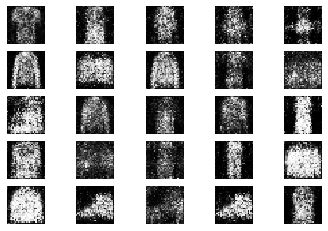

1401 [D loss: 0.672384, acc.: 56.25%] [G loss: 0.843161]
1402 [D loss: 0.613150, acc.: 65.62%] [G loss: 0.845398]
1403 [D loss: 0.731688, acc.: 48.44%] [G loss: 0.854422]
1404 [D loss: 0.678341, acc.: 51.56%] [G loss: 0.809496]
1405 [D loss: 0.664272, acc.: 57.81%] [G loss: 0.795847]
1406 [D loss: 0.609159, acc.: 62.50%] [G loss: 0.854818]
1407 [D loss: 0.618222, acc.: 71.88%] [G loss: 0.783506]
1408 [D loss: 0.590117, acc.: 71.88%] [G loss: 0.831341]
1409 [D loss: 0.673606, acc.: 50.00%] [G loss: 0.818258]
1410 [D loss: 0.549562, acc.: 76.56%] [G loss: 0.872777]
1411 [D loss: 0.620089, acc.: 65.62%] [G loss: 0.958006]
1412 [D loss: 0.625738, acc.: 56.25%] [G loss: 0.904257]
1413 [D loss: 0.603280, acc.: 71.88%] [G loss: 0.871489]
1414 [D loss: 0.598132, acc.: 68.75%] [G loss: 0.900484]
1415 [D loss: 0.632460, acc.: 64.06%] [G loss: 0.945536]
1416 [D loss: 0.605626, acc.: 70.31%] [G loss: 0.908844]
1417 [D loss: 0.618042, acc.: 62.50%] [G loss: 0.850544]
1418 [D loss: 0.647993, acc.: 6

1546 [D loss: 0.622788, acc.: 67.19%] [G loss: 0.921899]
1547 [D loss: 0.599815, acc.: 67.19%] [G loss: 0.926446]
1548 [D loss: 0.606280, acc.: 64.06%] [G loss: 0.969508]
1549 [D loss: 0.582853, acc.: 68.75%] [G loss: 0.964586]
1550 [D loss: 0.634740, acc.: 60.94%] [G loss: 0.938064]
1551 [D loss: 0.630870, acc.: 65.62%] [G loss: 0.944686]
1552 [D loss: 0.661822, acc.: 62.50%] [G loss: 1.001546]
1553 [D loss: 0.586423, acc.: 75.00%] [G loss: 0.928701]
1554 [D loss: 0.608536, acc.: 70.31%] [G loss: 0.891083]
1555 [D loss: 0.628098, acc.: 68.75%] [G loss: 0.963549]
1556 [D loss: 0.600634, acc.: 67.19%] [G loss: 0.913290]
1557 [D loss: 0.633569, acc.: 51.56%] [G loss: 0.849302]
1558 [D loss: 0.605392, acc.: 68.75%] [G loss: 0.956674]
1559 [D loss: 0.630102, acc.: 60.94%] [G loss: 0.912735]
1560 [D loss: 0.700363, acc.: 46.88%] [G loss: 0.848904]
1561 [D loss: 0.658889, acc.: 57.81%] [G loss: 0.854473]
1562 [D loss: 0.605597, acc.: 64.06%] [G loss: 0.844086]
1563 [D loss: 0.651064, acc.: 6

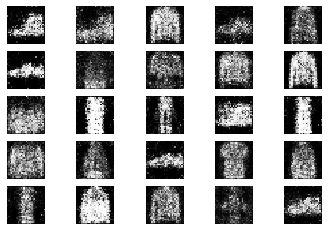

1601 [D loss: 0.590658, acc.: 70.31%] [G loss: 0.878095]
1602 [D loss: 0.661928, acc.: 60.94%] [G loss: 0.952987]
1603 [D loss: 0.567071, acc.: 71.88%] [G loss: 0.904667]
1604 [D loss: 0.610557, acc.: 68.75%] [G loss: 0.878255]
1605 [D loss: 0.665717, acc.: 60.94%] [G loss: 0.959459]
1606 [D loss: 0.623074, acc.: 56.25%] [G loss: 0.852068]
1607 [D loss: 0.646397, acc.: 67.19%] [G loss: 0.874352]
1608 [D loss: 0.631575, acc.: 68.75%] [G loss: 0.860379]
1609 [D loss: 0.637186, acc.: 60.94%] [G loss: 0.825925]
1610 [D loss: 0.598440, acc.: 68.75%] [G loss: 0.843915]
1611 [D loss: 0.721267, acc.: 54.69%] [G loss: 0.845467]
1612 [D loss: 0.566323, acc.: 71.88%] [G loss: 0.928636]
1613 [D loss: 0.603657, acc.: 67.19%] [G loss: 0.925795]
1614 [D loss: 0.658703, acc.: 57.81%] [G loss: 0.824958]
1615 [D loss: 0.679375, acc.: 54.69%] [G loss: 0.868208]
1616 [D loss: 0.601074, acc.: 68.75%] [G loss: 0.823251]
1617 [D loss: 0.608617, acc.: 68.75%] [G loss: 0.828415]
1618 [D loss: 0.728257, acc.: 5

1745 [D loss: 0.630674, acc.: 64.06%] [G loss: 0.918719]
1746 [D loss: 0.642324, acc.: 59.38%] [G loss: 0.811477]
1747 [D loss: 0.636316, acc.: 60.94%] [G loss: 0.879352]
1748 [D loss: 0.656211, acc.: 65.62%] [G loss: 0.852985]
1749 [D loss: 0.657715, acc.: 60.94%] [G loss: 0.851568]
1750 [D loss: 0.615240, acc.: 68.75%] [G loss: 0.905559]
1751 [D loss: 0.655107, acc.: 54.69%] [G loss: 0.908319]
1752 [D loss: 0.644177, acc.: 51.56%] [G loss: 0.948893]
1753 [D loss: 0.535766, acc.: 76.56%] [G loss: 1.021462]
1754 [D loss: 0.624824, acc.: 56.25%] [G loss: 0.865277]
1755 [D loss: 0.699385, acc.: 53.12%] [G loss: 0.891209]
1756 [D loss: 0.623380, acc.: 68.75%] [G loss: 0.899663]
1757 [D loss: 0.625215, acc.: 67.19%] [G loss: 0.900296]
1758 [D loss: 0.626480, acc.: 60.94%] [G loss: 0.874030]
1759 [D loss: 0.651488, acc.: 67.19%] [G loss: 0.886298]
1760 [D loss: 0.583554, acc.: 70.31%] [G loss: 0.927071]
1761 [D loss: 0.638890, acc.: 67.19%] [G loss: 0.987604]
1762 [D loss: 0.582030, acc.: 7

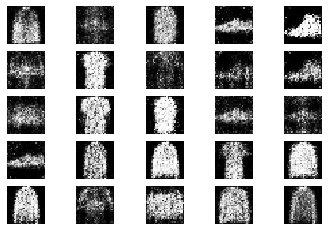

1801 [D loss: 0.649984, acc.: 59.38%] [G loss: 0.816364]
1802 [D loss: 0.671312, acc.: 60.94%] [G loss: 0.898665]
1803 [D loss: 0.658172, acc.: 57.81%] [G loss: 0.865542]
1804 [D loss: 0.612416, acc.: 57.81%] [G loss: 0.859574]
1805 [D loss: 0.589518, acc.: 68.75%] [G loss: 0.877002]
1806 [D loss: 0.652747, acc.: 64.06%] [G loss: 0.896994]
1807 [D loss: 0.673681, acc.: 57.81%] [G loss: 0.895208]
1808 [D loss: 0.687747, acc.: 56.25%] [G loss: 0.868944]
1809 [D loss: 0.568664, acc.: 70.31%] [G loss: 0.917286]
1810 [D loss: 0.663600, acc.: 56.25%] [G loss: 0.899332]
1811 [D loss: 0.597537, acc.: 65.62%] [G loss: 0.932612]
1812 [D loss: 0.620045, acc.: 64.06%] [G loss: 0.884856]
1813 [D loss: 0.650983, acc.: 62.50%] [G loss: 0.920791]
1814 [D loss: 0.635650, acc.: 62.50%] [G loss: 0.833498]
1815 [D loss: 0.580842, acc.: 67.19%] [G loss: 0.891682]
1816 [D loss: 0.648363, acc.: 62.50%] [G loss: 0.940427]
1817 [D loss: 0.617288, acc.: 65.62%] [G loss: 0.949222]
1818 [D loss: 0.614712, acc.: 7

1948 [D loss: 0.633093, acc.: 70.31%] [G loss: 0.897475]
1949 [D loss: 0.689463, acc.: 56.25%] [G loss: 0.937419]
1950 [D loss: 0.601694, acc.: 71.88%] [G loss: 0.991456]
1951 [D loss: 0.637919, acc.: 62.50%] [G loss: 0.949951]
1952 [D loss: 0.604822, acc.: 73.44%] [G loss: 0.916115]
1953 [D loss: 0.664351, acc.: 62.50%] [G loss: 0.942138]
1954 [D loss: 0.613749, acc.: 62.50%] [G loss: 0.892349]
1955 [D loss: 0.637658, acc.: 60.94%] [G loss: 0.881117]
1956 [D loss: 0.589594, acc.: 68.75%] [G loss: 0.921058]
1957 [D loss: 0.626947, acc.: 62.50%] [G loss: 0.895691]
1958 [D loss: 0.547595, acc.: 73.44%] [G loss: 0.809200]
1959 [D loss: 0.614791, acc.: 60.94%] [G loss: 0.872207]
1960 [D loss: 0.650123, acc.: 62.50%] [G loss: 0.943569]
1961 [D loss: 0.656811, acc.: 60.94%] [G loss: 0.878347]
1962 [D loss: 0.609587, acc.: 67.19%] [G loss: 0.994618]
1963 [D loss: 0.600694, acc.: 67.19%] [G loss: 0.838598]
1964 [D loss: 0.599427, acc.: 67.19%] [G loss: 0.890199]
1965 [D loss: 0.578550, acc.: 7

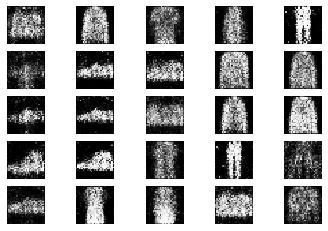

2001 [D loss: 0.644325, acc.: 54.69%] [G loss: 0.825874]
2002 [D loss: 0.610707, acc.: 71.88%] [G loss: 0.840857]
2003 [D loss: 0.583779, acc.: 64.06%] [G loss: 0.809923]
2004 [D loss: 0.645799, acc.: 65.62%] [G loss: 0.815639]
2005 [D loss: 0.636346, acc.: 62.50%] [G loss: 0.903031]
2006 [D loss: 0.605878, acc.: 73.44%] [G loss: 0.801787]
2007 [D loss: 0.711021, acc.: 56.25%] [G loss: 0.855516]
2008 [D loss: 0.642090, acc.: 64.06%] [G loss: 0.878983]
2009 [D loss: 0.549526, acc.: 79.69%] [G loss: 0.921842]
2010 [D loss: 0.613732, acc.: 68.75%] [G loss: 0.989310]
2011 [D loss: 0.484093, acc.: 85.94%] [G loss: 0.978755]
2012 [D loss: 0.563996, acc.: 71.88%] [G loss: 0.932467]
2013 [D loss: 0.676568, acc.: 59.38%] [G loss: 1.016126]
2014 [D loss: 0.637167, acc.: 62.50%] [G loss: 0.911301]
2015 [D loss: 0.659569, acc.: 60.94%] [G loss: 0.896796]
2016 [D loss: 0.693330, acc.: 59.38%] [G loss: 0.955657]
2017 [D loss: 0.671317, acc.: 59.38%] [G loss: 0.946140]
2018 [D loss: 0.698393, acc.: 6

2146 [D loss: 0.621100, acc.: 68.75%] [G loss: 0.888486]
2147 [D loss: 0.643659, acc.: 60.94%] [G loss: 0.865205]
2148 [D loss: 0.650460, acc.: 57.81%] [G loss: 0.879776]
2149 [D loss: 0.617629, acc.: 73.44%] [G loss: 0.868654]
2150 [D loss: 0.585520, acc.: 64.06%] [G loss: 0.856990]
2151 [D loss: 0.603070, acc.: 64.06%] [G loss: 0.900644]
2152 [D loss: 0.607777, acc.: 64.06%] [G loss: 0.852381]
2153 [D loss: 0.595958, acc.: 64.06%] [G loss: 0.891765]
2154 [D loss: 0.607428, acc.: 56.25%] [G loss: 0.908843]
2155 [D loss: 0.601753, acc.: 62.50%] [G loss: 0.796475]
2156 [D loss: 0.652375, acc.: 59.38%] [G loss: 0.847473]
2157 [D loss: 0.599936, acc.: 65.62%] [G loss: 0.851198]
2158 [D loss: 0.667235, acc.: 54.69%] [G loss: 0.940652]
2159 [D loss: 0.707281, acc.: 54.69%] [G loss: 0.996394]
2160 [D loss: 0.615932, acc.: 64.06%] [G loss: 0.934181]
2161 [D loss: 0.705456, acc.: 53.12%] [G loss: 0.944278]
2162 [D loss: 0.615186, acc.: 64.06%] [G loss: 0.884131]
2163 [D loss: 0.634789, acc.: 6

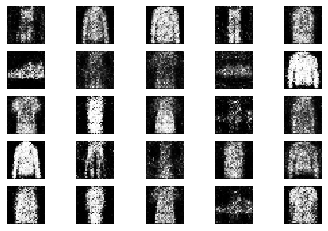

2201 [D loss: 0.609525, acc.: 68.75%] [G loss: 0.899806]
2202 [D loss: 0.636831, acc.: 67.19%] [G loss: 0.904743]
2203 [D loss: 0.647440, acc.: 71.88%] [G loss: 0.918962]
2204 [D loss: 0.604457, acc.: 60.94%] [G loss: 0.932489]
2205 [D loss: 0.606070, acc.: 64.06%] [G loss: 0.893695]
2206 [D loss: 0.682760, acc.: 46.88%] [G loss: 0.883648]
2207 [D loss: 0.668995, acc.: 59.38%] [G loss: 0.886450]
2208 [D loss: 0.634597, acc.: 57.81%] [G loss: 0.875866]
2209 [D loss: 0.653152, acc.: 60.94%] [G loss: 0.849852]
2210 [D loss: 0.637333, acc.: 67.19%] [G loss: 0.827687]
2211 [D loss: 0.606543, acc.: 68.75%] [G loss: 0.844389]
2212 [D loss: 0.618585, acc.: 67.19%] [G loss: 0.865493]
2213 [D loss: 0.680384, acc.: 54.69%] [G loss: 0.825092]
2214 [D loss: 0.627768, acc.: 65.62%] [G loss: 0.940455]
2215 [D loss: 0.606065, acc.: 71.88%] [G loss: 0.897073]
2216 [D loss: 0.651545, acc.: 62.50%] [G loss: 0.903825]
2217 [D loss: 0.558319, acc.: 71.88%] [G loss: 0.924566]
2218 [D loss: 0.674236, acc.: 5

2346 [D loss: 0.618634, acc.: 62.50%] [G loss: 0.971171]
2347 [D loss: 0.655373, acc.: 62.50%] [G loss: 0.920341]
2348 [D loss: 0.666117, acc.: 54.69%] [G loss: 0.826171]
2349 [D loss: 0.650600, acc.: 60.94%] [G loss: 0.857609]
2350 [D loss: 0.632598, acc.: 59.38%] [G loss: 0.904891]
2351 [D loss: 0.659971, acc.: 57.81%] [G loss: 0.915729]
2352 [D loss: 0.578074, acc.: 68.75%] [G loss: 0.884508]
2353 [D loss: 0.529170, acc.: 82.81%] [G loss: 0.932931]
2354 [D loss: 0.646530, acc.: 62.50%] [G loss: 0.882644]
2355 [D loss: 0.577067, acc.: 67.19%] [G loss: 0.888860]
2356 [D loss: 0.657831, acc.: 62.50%] [G loss: 0.910574]
2357 [D loss: 0.630312, acc.: 62.50%] [G loss: 1.005822]
2358 [D loss: 0.587655, acc.: 70.31%] [G loss: 0.877977]
2359 [D loss: 0.607747, acc.: 62.50%] [G loss: 0.896121]
2360 [D loss: 0.686104, acc.: 48.44%] [G loss: 0.923100]
2361 [D loss: 0.624250, acc.: 70.31%] [G loss: 0.918907]
2362 [D loss: 0.638684, acc.: 56.25%] [G loss: 0.982128]
2363 [D loss: 0.687593, acc.: 5

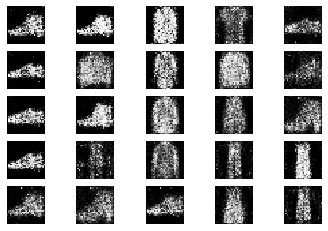

2401 [D loss: 0.624888, acc.: 57.81%] [G loss: 0.951871]
2402 [D loss: 0.628098, acc.: 62.50%] [G loss: 0.879166]
2403 [D loss: 0.665153, acc.: 50.00%] [G loss: 0.872910]
2404 [D loss: 0.725181, acc.: 59.38%] [G loss: 0.908092]
2405 [D loss: 0.630988, acc.: 67.19%] [G loss: 0.854775]
2406 [D loss: 0.628084, acc.: 67.19%] [G loss: 0.901004]
2407 [D loss: 0.667004, acc.: 62.50%] [G loss: 0.876876]
2408 [D loss: 0.644907, acc.: 67.19%] [G loss: 0.923442]
2409 [D loss: 0.638615, acc.: 60.94%] [G loss: 0.922121]
2410 [D loss: 0.616826, acc.: 65.62%] [G loss: 0.868521]
2411 [D loss: 0.640313, acc.: 65.62%] [G loss: 0.814989]
2412 [D loss: 0.616889, acc.: 64.06%] [G loss: 0.891625]
2413 [D loss: 0.619664, acc.: 64.06%] [G loss: 0.847907]
2414 [D loss: 0.560461, acc.: 67.19%] [G loss: 0.961384]
2415 [D loss: 0.637258, acc.: 68.75%] [G loss: 0.905935]
2416 [D loss: 0.620247, acc.: 57.81%] [G loss: 0.903855]
2417 [D loss: 0.617568, acc.: 67.19%] [G loss: 0.907263]
2418 [D loss: 0.653528, acc.: 5

2546 [D loss: 0.614288, acc.: 62.50%] [G loss: 0.797213]
2547 [D loss: 0.578227, acc.: 71.88%] [G loss: 0.944481]
2548 [D loss: 0.685795, acc.: 57.81%] [G loss: 0.870549]
2549 [D loss: 0.642659, acc.: 62.50%] [G loss: 0.888639]
2550 [D loss: 0.581415, acc.: 70.31%] [G loss: 0.872277]
2551 [D loss: 0.651625, acc.: 64.06%] [G loss: 0.878690]
2552 [D loss: 0.630394, acc.: 64.06%] [G loss: 0.887363]
2553 [D loss: 0.701830, acc.: 54.69%] [G loss: 0.871647]
2554 [D loss: 0.618430, acc.: 65.62%] [G loss: 0.913998]
2555 [D loss: 0.612667, acc.: 75.00%] [G loss: 0.923668]
2556 [D loss: 0.656024, acc.: 59.38%] [G loss: 0.944584]
2557 [D loss: 0.614754, acc.: 68.75%] [G loss: 0.945478]
2558 [D loss: 0.597593, acc.: 68.75%] [G loss: 0.901381]
2559 [D loss: 0.653678, acc.: 65.62%] [G loss: 0.858984]
2560 [D loss: 0.613719, acc.: 67.19%] [G loss: 0.914446]
2561 [D loss: 0.657443, acc.: 60.94%] [G loss: 0.898527]
2562 [D loss: 0.625864, acc.: 65.62%] [G loss: 0.829513]
2563 [D loss: 0.632336, acc.: 6

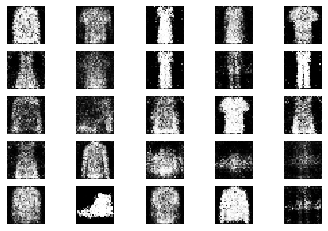

2601 [D loss: 0.616295, acc.: 68.75%] [G loss: 0.924641]
2602 [D loss: 0.694040, acc.: 54.69%] [G loss: 0.813834]
2603 [D loss: 0.590264, acc.: 71.88%] [G loss: 0.816287]
2604 [D loss: 0.611927, acc.: 67.19%] [G loss: 0.885611]
2605 [D loss: 0.640364, acc.: 64.06%] [G loss: 0.934406]
2606 [D loss: 0.636489, acc.: 62.50%] [G loss: 0.827319]
2607 [D loss: 0.668369, acc.: 60.94%] [G loss: 0.921247]
2608 [D loss: 0.686868, acc.: 50.00%] [G loss: 0.836471]
2609 [D loss: 0.627152, acc.: 64.06%] [G loss: 0.928495]
2610 [D loss: 0.636285, acc.: 60.94%] [G loss: 0.870961]
2611 [D loss: 0.628443, acc.: 62.50%] [G loss: 0.841857]
2612 [D loss: 0.656826, acc.: 60.94%] [G loss: 0.833186]
2613 [D loss: 0.596059, acc.: 67.19%] [G loss: 0.914714]
2614 [D loss: 0.625046, acc.: 65.62%] [G loss: 0.952002]
2615 [D loss: 0.594152, acc.: 68.75%] [G loss: 0.970637]
2616 [D loss: 0.620787, acc.: 68.75%] [G loss: 0.920923]
2617 [D loss: 0.651995, acc.: 68.75%] [G loss: 0.937042]
2618 [D loss: 0.608033, acc.: 6

2747 [D loss: 0.634382, acc.: 60.94%] [G loss: 0.780489]
2748 [D loss: 0.635614, acc.: 70.31%] [G loss: 0.860089]
2749 [D loss: 0.597428, acc.: 73.44%] [G loss: 0.837185]
2750 [D loss: 0.684883, acc.: 60.94%] [G loss: 0.804547]
2751 [D loss: 0.695687, acc.: 45.31%] [G loss: 0.839863]
2752 [D loss: 0.607718, acc.: 71.88%] [G loss: 0.924575]
2753 [D loss: 0.650128, acc.: 54.69%] [G loss: 0.904767]
2754 [D loss: 0.620692, acc.: 60.94%] [G loss: 0.875720]
2755 [D loss: 0.596636, acc.: 70.31%] [G loss: 0.919719]
2756 [D loss: 0.588159, acc.: 71.88%] [G loss: 0.890101]
2757 [D loss: 0.652387, acc.: 56.25%] [G loss: 0.884683]
2758 [D loss: 0.575620, acc.: 68.75%] [G loss: 0.877616]
2759 [D loss: 0.615436, acc.: 65.62%] [G loss: 0.879681]
2760 [D loss: 0.646637, acc.: 53.12%] [G loss: 0.839894]
2761 [D loss: 0.649953, acc.: 62.50%] [G loss: 0.942056]
2762 [D loss: 0.631566, acc.: 62.50%] [G loss: 1.026359]
2763 [D loss: 0.625267, acc.: 67.19%] [G loss: 0.930504]
2764 [D loss: 0.672162, acc.: 5

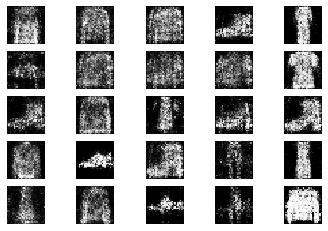

2801 [D loss: 0.658825, acc.: 67.19%] [G loss: 0.936170]
2802 [D loss: 0.638089, acc.: 64.06%] [G loss: 0.956403]
2803 [D loss: 0.710003, acc.: 51.56%] [G loss: 0.981881]
2804 [D loss: 0.674235, acc.: 57.81%] [G loss: 0.889408]
2805 [D loss: 0.608526, acc.: 67.19%] [G loss: 0.856389]
2806 [D loss: 0.693478, acc.: 57.81%] [G loss: 0.788287]
2807 [D loss: 0.651949, acc.: 65.62%] [G loss: 0.814825]
2808 [D loss: 0.618242, acc.: 71.88%] [G loss: 0.840212]
2809 [D loss: 0.601373, acc.: 65.62%] [G loss: 0.837220]
2810 [D loss: 0.611085, acc.: 68.75%] [G loss: 0.900506]
2811 [D loss: 0.600217, acc.: 67.19%] [G loss: 0.826162]
2812 [D loss: 0.590659, acc.: 67.19%] [G loss: 0.862431]
2813 [D loss: 0.623667, acc.: 59.38%] [G loss: 0.836650]
2814 [D loss: 0.628317, acc.: 62.50%] [G loss: 0.891900]
2815 [D loss: 0.636889, acc.: 60.94%] [G loss: 0.857756]
2816 [D loss: 0.637060, acc.: 64.06%] [G loss: 0.867128]
2817 [D loss: 0.678180, acc.: 59.38%] [G loss: 0.865878]
2818 [D loss: 0.632836, acc.: 6

2945 [D loss: 0.611352, acc.: 71.88%] [G loss: 0.958217]
2946 [D loss: 0.627282, acc.: 60.94%] [G loss: 0.972796]
2947 [D loss: 0.639675, acc.: 65.62%] [G loss: 0.939250]
2948 [D loss: 0.706835, acc.: 51.56%] [G loss: 0.932943]
2949 [D loss: 0.547554, acc.: 79.69%] [G loss: 0.942777]
2950 [D loss: 0.673839, acc.: 54.69%] [G loss: 0.917599]
2951 [D loss: 0.604258, acc.: 70.31%] [G loss: 0.973256]
2952 [D loss: 0.634212, acc.: 60.94%] [G loss: 0.852957]
2953 [D loss: 0.703171, acc.: 54.69%] [G loss: 0.899895]
2954 [D loss: 0.601501, acc.: 68.75%] [G loss: 0.990388]
2955 [D loss: 0.640613, acc.: 62.50%] [G loss: 0.950023]
2956 [D loss: 0.709715, acc.: 57.81%] [G loss: 0.919752]
2957 [D loss: 0.607531, acc.: 73.44%] [G loss: 0.877968]
2958 [D loss: 0.661580, acc.: 56.25%] [G loss: 0.807925]
2959 [D loss: 0.644902, acc.: 65.62%] [G loss: 0.940337]
2960 [D loss: 0.646613, acc.: 62.50%] [G loss: 0.887670]
2961 [D loss: 0.648620, acc.: 51.56%] [G loss: 0.989241]
2962 [D loss: 0.601331, acc.: 6

In [3]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)